In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pubg-finish-placement-prediction/train_V2.csv
/kaggle/input/pubg-finish-placement-prediction/test_V2.csv
/kaggle/input/pubg-finish-placement-prediction/sample_submission_V2.csv


In [2]:
# library 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **SETTING**

In [3]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random, gc, os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
sns.set(style='whitegrid', font_scale=1.0)

SEED = 42
random.seed(SEED); np.random.seed(SEED)

DATA_DIR = '/kaggle/input/pubg-finish-placement-prediction'
WORK_DIR = '/kaggle/working'
train_path = os.path.join(DATA_DIR, 'train_V2.csv')
test_path  = os.path.join(DATA_DIR, 'test_V2.csv')

train_path, test_path

('/kaggle/input/pubg-finish-placement-prediction/train_V2.csv',
 '/kaggle/input/pubg-finish-placement-prediction/test_V2.csv')

# **Load Data**

In [4]:
train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)
train.shape, test.shape

((4446966, 29), (1934174, 28))

In [5]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.0000,0,0,0,60,1241,0,0,0.0000,1306,squad-fpp,28,26,-1,0,0.0000,0,0.0000,0,0,244.8000,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.4700,0,0,0,57,0,0,0,0.0000,1777,squad-fpp,26,25,1484,0,0.0045,0,11.0400,0,0,"1,434.0000",5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.0000,0,0,0,47,0,0,0,0.0000,1318,duo,50,47,1491,0,0.0000,0,0.0000,0,0,161.8000,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.9000,0,0,0,75,0,0,0,0.0000,1436,squad-fpp,31,30,1408,0,0.0000,0,0.0000,0,0,202.7000,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.0000,0,0,0,45,0,1,1,58.5300,1424,solo-fpp,97,95,1560,0,0.0000,0,0.0000,0,0,49.7500,2,0,0.1875


## **Preprocessing**

In [6]:
train.isna().sum().sort_values(ascending=False).head(10)

winPlacePerc       1
matchType          0
winPoints          0
weaponsAcquired    0
walkDistance       0
vehicleDestroys    0
teamKills          0
swimDistance       0
roadKills          0
rideDistance       0
dtype: int64

In [7]:
# Drop missing target rows (known single row)
before = len(train)
train = train[~train['winPlacePerc'].isna()].reset_index(drop=True)
after = len(train)
print('Dropped:', before - after)

Dropped: 1


In [8]:
# Numeric NA fill (safety)
num_cols_train = train.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols_train:
    if train[c].isna().any():
        train[c] = train[c].fillna(train[c].median())
train[num_cols_train].isna().sum().sum()

0

## **Feature Engineering**

In [9]:
# totalDistance
train['totalDistance'] = train['rideDistance'] + train['swimDistance'] + train['walkDistance']
test['totalDistance']  = test['rideDistance']  + test['swimDistance']  + test['walkDistance']
train['totalDistance'].describe(), test['totalDistance'].describe()

(count   4,446,965.0000
 mean        1,764.8432
 std         2,183.1170
 min             0.0000
 25%           158.1000
 50%           788.2000
 75%         2,728.4591
 max        41,270.1000
 Name: totalDistance, dtype: float64,
 count   1,934,174.0000
 mean        1,744.7523
 std         2,159.2685
 min             0.0000
 25%           157.1000
 50%           777.5000
 75%         2,702.0000
 max        40,799.9200
 Name: totalDistance, dtype: float64)

In [10]:
# headshotRate (avoid div by zero)
train['headshotRate'] = (train['headshotKills'] / train['kills'].clip(lower=1)).astype(np.float32)
test['headshotRate']  = (test['headshotKills']  / test['kills'].clip(lower=1)).astype(np.float32)
train['headshotRate'].describe()

count   4,446,965.0000
mean            0.1031
std             0.2600
min             0.0000
25%             0.0000
50%             0.0000
75%             0.0000
max             1.0000
Name: headshotRate, dtype: float64

In [11]:
# Simplify matchType into solo/duo/squad/other (no function version)
train['matchTypeSimple'] = 'other'
train.loc[train['matchType'].str.lower().str.contains('solo'),  'matchTypeSimple'] = 'solo'
train.loc[train['matchType'].str.lower().str.contains('duo'),   'matchTypeSimple'] = 'duo'
train.loc[train['matchType'].str.lower().str.contains('squad'), 'matchTypeSimple'] = 'squad'

test['matchTypeSimple'] = 'other'
test.loc[test['matchType'].str.lower().str.contains('solo'),  'matchTypeSimple'] = 'solo'
test.loc[test['matchType'].str.lower().str.contains('duo'),   'matchTypeSimple'] = 'duo'
test.loc[test['matchType'].str.lower().str.contains('squad'), 'matchTypeSimple'] = 'squad'

train['matchTypeSimple'].value_counts(normalize=True)

matchTypeSimple
squad   0.5398
duo     0.2959
solo    0.1621
other   0.0022
Name: proportion, dtype: float64

In [12]:
# playersJoined per match (separately for train/test)
train_players = train.groupby('matchId')['Id'].count().rename('playersJoined')
test_players  = test.groupby('matchId')['Id'].count().rename('playersJoined')
train = train.merge(train_players, on='matchId', how='left')
test  = test.merge(test_players,  on='matchId', how='left')
train['playersJoined'].describe()

count   4,446,965.0000
mean           94.1948
std             6.6864
min             2.0000
25%            93.0000
50%            95.0000
75%            97.0000
max           100.0000
Name: playersJoined, dtype: float64

## **Quick EDA**

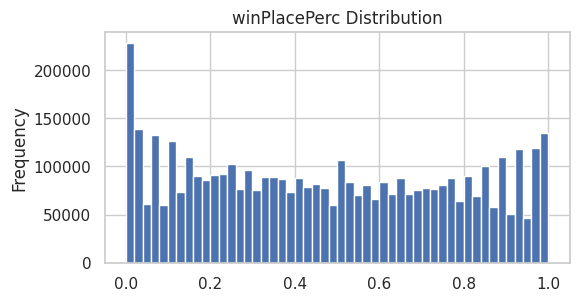

,winPlacePerc
count,"4,446,965.0000"
mean,0.4728
std,0.3074
min,0.0000
25%,0.2000
50%,0.4583
75%,0.7407
max,1.0000


In [13]:
# Target distribution
train['winPlacePerc'].plot(kind='hist', bins=50, title='winPlacePerc Distribution', figsize=(6,3))
plt.show()
train[['winPlacePerc']].describe()

In [14]:
drop_cols_tmp = ['Id','groupId','matchId','matchType']  # 필요시 더 추가
corr_cols = [c for c in train.columns if c not in drop_cols_tmp]

# 비-수치형 컬럼 점검
non_numeric = train[corr_cols].select_dtypes(exclude=['number']).columns.tolist()
non_numeric


['matchTypeSimple']

In [15]:
# Correlation top 15 (fast)
corr_cols_num = train[corr_cols].select_dtypes(include=['number']).columns.tolist()
corr = train[corr_cols_num].corr()['winPlacePerc'].abs().sort_values(ascending=False)
corr.head(15)


winPlacePerc      1.0000
walkDistance      0.8109
killPlace         0.7191
totalDistance     0.6770
boosts            0.6342
weaponsAcquired   0.5838
damageDealt       0.4405
heals             0.4279
kills             0.4199
longestKill       0.4102
killStreaks       0.3776
rideDistance      0.3429
assists           0.2994
DBNOs             0.2800
headshotKills     0.2777
Name: winPlacePerc, dtype: float64

## **Encode**

In [16]:

# One-hot for matchTypeSimple
train = pd.get_dummies(train, columns=['matchTypeSimple'])
test  = pd.get_dummies(test,  columns=['matchTypeSimple'])

target = 'winPlacePerc'
drop_cols = ['Id','groupId','matchId','matchType', target]

features = [c for c in train.columns if c not in drop_cols]

# Align columns (no functions)
for c in features:
    if c not in test.columns:
        test[c] = 0
for c in test.columns:
    if c not in features and c not in ['Id','groupId','matchId','matchType']:
        if c in train.columns:
            pass
        else:
            train[c] = 0

features = [c for c in train.columns if c not in drop_cols]
len(features)


31

## **Train / Test Split**

In [17]:

MAX_TRAIN_ROWS = 1_000_000  # 시간 여유되면 늘리기
if len(train) > MAX_TRAIN_ROWS:
    train_sample = train.sample(MAX_TRAIN_ROWS, random_state=SEED)
else:
    train_sample = train

X = train_sample[features]
y = train_sample[target].astype(np.float32)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, random_state=SEED
)

X_train.shape, X_valid.shape


((900000, 31), (100000, 31))

## **LightGBM Baseline**

In [18]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'min_data_in_leaf': 100,
    'random_state': SEED,
    'n_jobs': -1
}

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=['train','valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=200)
    ]
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 900000, number of used features: 31
[LightGBM] [Info] Start training from score 0.472680
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.0784615	valid's rmse: 0.0790586
[400]	train's rmse: 0.0767039	valid's rmse: 0.077945
[600]	train's rmse: 0.0758505	valid's rmse: 0.0776363
[800]	train's rmse: 0.0751989	valid's rmse: 0.0774833
[1000]	train's rmse: 0.0746401	valid's rmse: 0.0773676
[1200]	train's rmse: 0.0741515	valid's rmse: 0.0772963
[1400]	train's rmse: 0.073691	valid's rmse: 0.0772418
[1600]	train's rmse: 0.0732697	valid's rmse: 0.0771986
[1800]	train's rmse: 0.0728541	valid's rmse: 0.0771668
[2000]	train's rmse: 0.0724665	valid's rmse: 0.0771453
Did not meet early stopping. Best iteration is:
[19

In [19]:

# Validation RMSE
pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
rmse = mean_squared_error(y_valid, pred_valid, squared=False)
rmse


0.07714348880091364

## **Save Submission**

In [20]:
X_test = test[features]
test_pred = model.predict(X_test, num_iteration=model.best_iteration)
test_pred = np.clip(test_pred, 0.0, 1.0)  # clip to [0,1]

submission = pd.DataFrame({
    'Id': test['Id'],
    'winPlacePerc': test_pred
})
submission.head()

,Id,winPlacePerc
0,9329eb41e215eb,0.2120
1,639bd0dcd7bda8,0.9215
2,63d5c8ef8dfe91,0.6993
3,cf5b81422591d1,0.5341
4,ee6a295187ba21,0.9242


In [21]:
sub_path = os.path.join(WORK_DIR, 'submission.csv')
submission.to_csv(sub_path, index=False)
sub_path


'/kaggle/working/submission.csv'


# 📈 PUBG Finish Placement Prediction — 파라미터 튜닝 & 앙상블 확장
**자동 추가됨:** 2025-09-02 07:19:10

아래 섹션은 기존 노트북의 워크플로에 **모델 파라미터 튜닝**과 **모델 앙상블**을 체계적으로 추가합니다.

- **튜닝**: `RandomizedSearchCV` 기반으로 `RandomForestRegressor`, `GradientBoostingRegressor`를 탐색하고, 가능하면 `XGBRegressor`/`LGBMRegressor`도 자동으로 시도합니다.
- **앙상블**: 튜닝된 개별 모델의 예측을 **StackingRegressor** (최종 메타모델: `RidgeCV`)로 결합하고, 보조적으로 **단순 가중 평균(학습 기반 가중치)**도 제공합니다.
- **메트릭**: 캐글 대회 평가와 동일하게 **MAE (Mean Absolute Error)** 를 기본으로 사용합니다.
- **출력**: `test`가 있다면 **submission 파일**(`submission_tuned_ensemble.csv`)까지 생성합니다.

> ⚠️ 이 섹션은 **기존 노트북 변수**(`X_train`, `y_train`, `X_valid`, `y_valid`, `X_test`, `train`, `test`)를 **자동 감지**해 사용합니다.  
> 존재하지 않는 경우에는 `train`/`test`로부터 **전처리**(ID 제거, 범주형 더미화 등)를 수행합니다.


In [ ]:

# === 공통 설정 ===
import warnings, math, sys, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

from typing import Dict, Any, Tuple, Optional
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor

# xgboost/lightgbm가 설치되어 있으면 사용 (없어도 문제 없이 진행)
has_xgb = False
has_lgbm = False
try:
    from xgboost import XGBRegressor
    has_xgb = True
except Exception as e:
    print("[INFO] xgboost 미설치 또는 로드 실패:", e)

try:
    from lightgbm import LGBMRegressor
    has_lgbm = True
except Exception as e:
    print("[INFO] lightgbm 미설치 또는 로드 실패:", e)

def infer_datasets(glob: Dict[str, Any]) -> Tuple[pd.DataFrame, pd.Series, Optional[pd.DataFrame], Optional[pd.Series], Optional[pd.DataFrame]]:
    \"\"\"
    가능한 경우:
      - X_train, y_train[, X_valid, y_valid, X_test] 가 이미 존재
      - 그렇지 않으면 train/test DataFrame으로부터 전처리하여 생성
    반환: X_train, y_train, X_valid, y_valid, X_test
    \"\"\"
    # 1) 이미 준비된 feature matrix가 있으면 그대로 사용
    X_train = glob.get("X_train", None)
    y_train = glob.get("y_train", None)
    X_valid = glob.get("X_valid", None)
    y_valid = glob.get("y_valid", None)
    X_test  = glob.get("X_test", None)

    if X_train is not None and y_train is not None:
        # ensure pandas DataFrame/Series
        if not isinstance(X_train, pd.DataFrame):
            X_train = pd.DataFrame(X_train)
        if not isinstance(y_train, (pd.Series, pd.DataFrame)):
            y_train = pd.Series(y_train, name="winPlacePerc")
        if isinstance(y_train, pd.DataFrame):
            y_train = y_train.iloc[:,0]

        # if no valid set, try to find y_valid
        if X_valid is not None and y_valid is not None:
            if not isinstance(X_valid, pd.DataFrame):
                X_valid = pd.DataFrame(X_valid)
            if isinstance(y_valid, pd.DataFrame):
                y_valid = y_valid.iloc[:,0]
            elif not isinstance(y_valid, pd.Series):
                y_valid = pd.Series(y_valid, name="winPlacePerc")
        else:
            X_valid, y_valid = None, None

        # return immediately, rely on user's preprocessing
        return X_train, y_train, X_valid, y_valid, X_test

    # 2) train/test 로부터 구성
    if "train" not in glob:
        raise RuntimeError("train DataFrame이 필요합니다. (혹은 X_train/y_train을 미리 정의하세요)")

    train_df: pd.DataFrame = glob["train"].copy()
    test_df: Optional[pd.DataFrame] = glob.get("test", None)
    target_col = "winPlacePerc"
    if target_col not in train_df.columns:
        # 일부 커스텀 노트북에서는 다른 이름을 쓸 수 있으므로 힌트 출력
        raise RuntimeError(f"train DataFrame에 '{target_col}' 컬럼이 없습니다. 기존 변수(X_train, y_train)를 제공해 주세요.")

    # ID/키 컬럼 제거
    drop_cols = [c for c in ["Id", "groupId", "matchId"] if c in train_df.columns]
    # 범주형 처리: matchType
    cat_cols = [c for c in train_df.select_dtypes(include=["object", "category"]).columns if c != target_col]

    y = train_df[target_col].astype(float).clip(0.0, 1.0)
    X = train_df.drop([target_col] + drop_cols, axis=1, errors="ignore")

    # 원-핫 인코딩 (matchType 등)
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

    # 결측치 보정
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(0)

    # 검증 세트 분할(만약 사용자가 이미 만들지 않았다면)
    X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.15, random_state=42)

    # test 처리
    X_te = None
    if test_df is not None:
        test_df = test_df.copy()
        Xtest = test_df.drop(drop_cols, axis=1, errors="ignore")
        cat_cols_te = [c for c in Xtest.select_dtypes(include=["object", "category"]).columns]
        Xtest = pd.get_dummies(Xtest, columns=cat_cols_te, drop_first=True)
        Xtest = Xtest.replace([np.inf, -np.inf], np.nan).fillna(0)
        # 학습과 동일한 컬럼 정렬(누락/추가 대비)
        Xtest = Xtest.reindex(columns=X.columns, fill_value=0)
        X_te = Xtest

    return X_tr, y_tr, X_va, y_va, X_te

print("[OK] 데이터셋 자동 감지/구성 준비됨.")


In [ ]:

# === 하이퍼파라미터 튜닝 ===
from scipy.stats import randint, uniform, loguniform

X_tr, y_tr, X_va, y_va, X_te = infer_datasets(globals())

scoring = "neg_mean_absolute_error"
cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

search_results = {}
best_models = {}

# 1) RandomForest
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
rf_dist = {
    "n_estimators": randint(300, 1200),
    "max_depth": [None] + list(range(6, 28)),
    "min_samples_split": randint(2, 12),
    "min_samples_leaf": randint(1, 6),
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False],
}
rf_rs = RandomizedSearchCV(rf, rf_dist, n_iter=35, cv=cv, scoring=scoring, random_state=RANDOM_STATE, n_jobs=-1, verbose=1)
rf_rs.fit(X_tr, y_tr)
best_models["rf"] = rf_rs.best_estimator_
search_results["rf"] = rf_rs.cv_results_
print("[RF] best params:", rf_rs.best_params_)

# 2) GradientBoosting
gb = GradientBoostingRegressor(random_state=RANDOM_STATE)
gb_dist = {
    "n_estimators": randint(300, 1100),
    "learning_rate": loguniform(1e-3, 3e-1),
    "max_depth": randint(2, 7),
    "min_samples_leaf": randint(1, 6),
    "subsample": uniform(0.6, 0.4),  # 0.6~1.0
    "loss": ["squared_error", "absolute_error", "huber"],
}
gb_rs = RandomizedSearchCV(gb, gb_dist, n_iter=35, cv=cv, scoring=scoring, random_state=RANDOM_STATE, n_jobs=-1, verbose=1)
gb_rs.fit(X_tr, y_tr)
best_models["gb"] = gb_rs.best_estimator_
search_results["gb"] = gb_rs.cv_results_
print("[GB] best params:", gb_rs.best_params_)

# 3) XGBoost (optional)
if has_xgb:
    xgb = XGBRegressor(
        random_state=RANDOM_STATE,
        tree_method="hist",
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=1.0,
        objective="reg:squarederror",
        n_jobs=-1,
    )
    xgb_dist = {
        "n_estimators": randint(400, 1400),
        "max_depth": randint(3, 10),
        "learning_rate": loguniform(1e-3, 3e-1),
        "subsample": uniform(0.6, 0.4),
        "colsample_bytree": uniform(0.6, 0.4),
        "reg_alpha": loguniform(1e-8, 10),
        "reg_lambda": loguniform(1e-3, 50),
        "min_child_weight": randint(1, 10),
        "gamma": loguniform(1e-8, 10),
    }
    xgb_rs = RandomizedSearchCV(xgb, xgb_dist, n_iter=35, cv=cv, scoring=scoring, random_state=RANDOM_STATE, n_jobs=-1, verbose=1)
    xgb_rs.fit(X_tr, y_tr)
    best_models["xgb"] = xgb_rs.best_estimator_
    search_results["xgb"] = xgb_rs.cv_results_
    print("[XGB] best params:", xgb_rs.best_params_)
else:
    print("[XGB] not downloaded")

# 4) LightGBM (optional)
if has_lgbm:
    lgbm = LGBMRegressor(random_state=RANDOM_STATE, n_estimators=1000)
    lgbm_dist = {
        "n_estimators": randint(400, 1600),
        "num_leaves": randint(16, 128),
        "max_depth": [-1] + list(range(4, 16)),
        "learning_rate": loguniform(1e-3, 3e-1),
        "subsample": uniform(0.6, 0.4),
        "colsample_bytree": uniform(0.6, 0.4),
        "min_child_samples": randint(5, 50),
        "reg_alpha": loguniform(1e-8, 10),
        "reg_lambda": loguniform(1e-3, 50),
    }
    lgbm_rs = RandomizedSearchCV(lgbm, lgbm_dist, n_iter=35, cv=cv, scoring=scoring, random_state=RANDOM_STATE, n_jobs=-1, verbose=1)
    lgbm_rs.fit(X_tr, y_tr)
    best_models["lgbm"] = lgbm_rs.best_estimator_
    search_results["lgbm"] = lgbm_rs.cv_results_
    print("[LGBM] best params:", lgbm_rs.best_params_)
else:
    print("[LGBM] not downloaded")

# 검증 MAE 출력
def eval_model(name, model, X_tr, y_tr, X_va, y_va):
    model.fit(X_tr, y_tr)
    if X_va is not None and y_va is not None:
        pred = model.predict(X_va)
        mae = mean_absolute_error(y_va, np.clip(pred, 0, 1))
        print(f"[{name}] valid MAE: {mae:.6f}")
        return mae
    return None

valid_mae = {}
for name, model in best_models.items():
    valid_mae[name] = eval_model(name, model, X_tr, y_tr, X_va, y_va)

print("MAE:", valid_mae)


In [ ]:

# === 앙상블 (Stacking + 가중 평균) ===
base_estimators = []
for key in ["rf", "gb", "xgb", "lgbm"]:
    if key in globals()["best_models"]:
        base_estimators.append((key, globals()["best_models"][key]))

if len(base_estimators) < 2:
    print("models lack (at least two models needed)")
else:
    # 1) Stacking
    final_estimator = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0))
    stacker = StackingRegressor(estimators=base_estimators, final_estimator=final_estimator, n_jobs=-1, passthrough=False, cv=5)
    stacker.fit(X_tr, y_tr)
    if X_va is not None and y_va is not None:
        pred_st = stacker.predict(X_va).clip(0, 1)
        mae_st = mean_absolute_error(y_va, pred_st)
        print(f"[STACKING] valid MAE: {mae_st:.6f}")

    # 2) 학습 기반 가중 평균 (선형회귀로 가중치 학습; 가중치 제약은 두지 않음)
    #    성능/안정성을 위해 Ridge를 사용
    oof_preds = []
    for name, model in base_estimators:
        # 각 모델을 학습 데이터 전체로 학습 후, 검증 세트 예측을 쌓는다
        model.fit(X_tr, y_tr)
        if X_va is not None and y_va is not None:
            oof_preds.append(model.predict(X_va).reshape(-1, 1))
    if X_va is not None and y_va is not None:
        oof_mat = np.hstack(oof_preds)
        weight_learner = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0))
        weight_learner.fit(oof_mat, y_va)
        learned_weights = weight_learner.coef_
        w_norm = learned_weights / (np.abs(learned_weights).sum() + 1e-9)
        blended_pred = (oof_mat @ w_norm).clip(0, 1)
        mae_blend = mean_absolute_error(y_va, blended_pred)
        print(f"[BLEND] valid MAE: {mae_blend:.6f} (weights: {w_norm})")

    # 제출 파일 생성
    if X_te is not None:
        # 추천: stacking 사용. 보조로 blend도 생성
        sub_pred_stack = np.clip(stacker.predict(X_te), 0, 1)
        sub_df_stack = None
        if "test" in globals() and "Id" in globals()["test"].columns:
            sub_df_stack = pd.DataFrame({"Id": globals()["test"]["Id"].values, "winPlacePerc": sub_pred_stack})
        else:
            sub_df_stack = pd.DataFrame({"winPlacePerc": sub_pred_stack})

        stack_path = "submission_tuned_ensemble_stacking.csv"
        sub_df_stack.to_csv(stack_path, index=False)
        print(f"[SAVE] {stack_path} 저장 완료")

        # blend도 가능하면 저장
        try:
            base_preds_test = []
            for name, model in base_estimators:
                base_preds_test.append(model.predict(X_te).reshape(-1, 1))
            test_mat = np.hstack(base_preds_test)
            # 가중치가 존재하면 사용, 없으면 동일가중
            if 'w_norm' in locals():
                sub_pred_blend = np.clip(test_mat @ w_norm, 0, 1)
            else:
                sub_pred_blend = np.clip(test_mat.mean(axis=1), 0, 1)
            sub_df_blend = None
            if "test" in globals() and "Id" in globals()["test"].columns:
                sub_df_blend = pd.DataFrame({"Id": globals()["test"]["Id"].values, "winPlacePerc": sub_pred_blend})
            else:
                sub_df_blend = pd.DataFrame({"winPlacePerc": sub_pred_blend})
            blend_path = "submission_tuned_ensemble_blend.csv"
            sub_df_blend.to_csv(blend_path, index=False)
            print(f"[SAVE] {blend_path} stored completed")
        except Exception as e:
            print("[BLEND SAVE] skip:", e)
